In [48]:
import os
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
import pickle as pkl
%matplotlib inline
sns.set_style('whitegrid')
# pd.reset_option("display.max_rows")
drive.mount('/content/drive/')
os.chdir("/content/drive/My Drive/colab")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [49]:
dir = 'titanic'
data = pd.read_csv(dir + '/train.csv')
data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<h3> Checking for duplicate rows</h3>

In [51]:
print(f'''No of Duplicate rows: {len(data) - data[data.duplicated(['Name'])==False].shape[0]}''')

No of Duplicate rows: 0


<h3> Checking for missing values</h3>

In [97]:
pd.DataFrame(100*data.isnull().sum()/data.shape[0], columns=['Missing (in %)'])


,Missing (in %)
PassengerId,0.000000
Survived,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
Age,19.865320
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.000000


<h3> There exists 3 columns with missing values : Age, Cabin and Embarked</h3>

Text(0.5, 0, 'Survived')

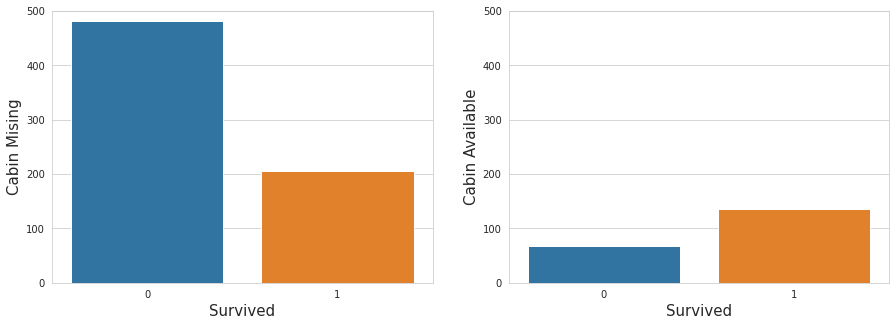

In [53]:
data['Cabin_ref'] = data['Cabin'].isnull()
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.countplot(x= data[data['Cabin_ref']]['Survived'])
plt.ylim(0, 500)
plt.ylabel('Cabin Mising', fontsize = 15)
plt.xlabel('Survived', fontsize = 15)
plt.subplot(1,2,2)
sns.countplot(x= data[data['Cabin_ref']==False]['Survived'])
plt.ylim(0, 500)
plt.ylabel('Cabin Available', fontsize = 15)
plt.xlabel('Survived', fontsize = 15)

<h2>Cabin information missing indicates less chance of survival</h2>

In [54]:
data['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

Text(0.5, 0, 'Age')

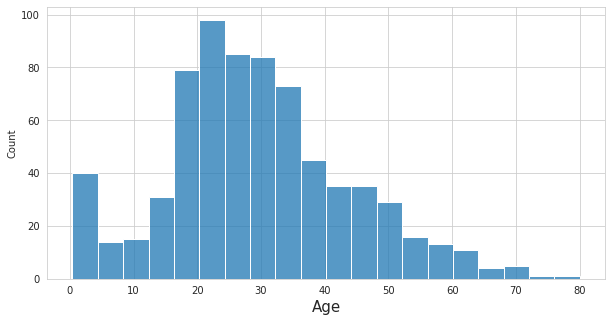

In [55]:
plt.figure(figsize=(10, 5))
sns.histplot(data['Age'])
plt.xlabel('Age', fontsize = 15)

Text(0.5, 0, 'Survived')

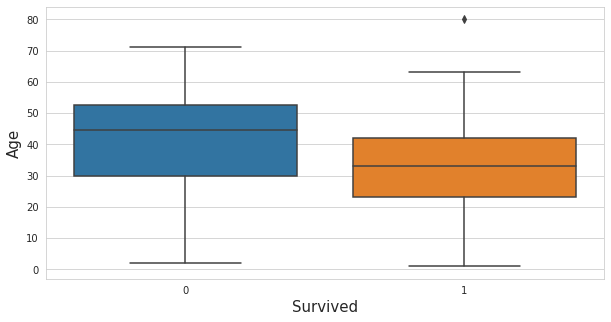

In [56]:
plt.figure(figsize=(10, 5))
sns.boxplot(x = data.dropna()['Survived'], y = data.dropna()['Age'], orient = 'v')
plt.ylabel('Age', fontsize = 15)
plt.xlabel('Survived', fontsize = 15)

In [57]:
len(data['Ticket'].unique())

681

<h3>This feature can be dropped</h3>

In [58]:
df = data.copy()
df.drop(['PassengerId', 'Name', 'Cabin', 'Cabin_ref', 'Ticket'], axis = 1, inplace = True)
df['Cabin_Misssing'] = [1 if x is True else 0 for x in data['Cabin_ref']]
df.dropna(inplace=True)
df.shape

(712, 9)

In [59]:
pd.DataFrame(100*df.isnull().sum()/df.shape[0], columns=['Missing (in %)'])

,Missing (in %)
Survived,0.0
Pclass,0.0
Sex,0.0
Age,0.0
SibSp,0.0
Parch,0.0
Fare,0.0
Embarked,0.0
Cabin_Misssing,0.0


In [60]:
df.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_Misssing
0,0,3,male,22.0,1,0,7.2500,S,1
1,1,1,female,38.0,1,0,71.2833,C,0
2,1,3,female,26.0,0,0,7.9250,S,1
3,1,1,female,35.0,1,0,53.1000,S,0
4,0,3,male,35.0,0,0,8.0500,S,1


Text(0.5, 0, 'Survived')

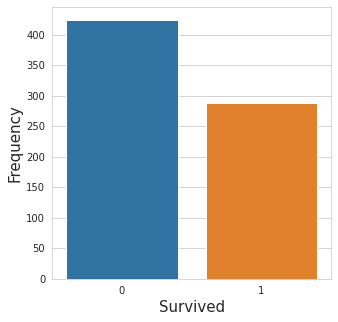

In [61]:
plt.figure(figsize=(5, 5))
sns.countplot(df['Survived'])
plt.ylabel('Frequency', fontsize = 15)
plt.xlabel('Survived', fontsize = 15)

<h3> Almost balanced dataset. Hence accuracy is a good metric for evaluation</h3>

Text(0.5, 0, 'SibSp')

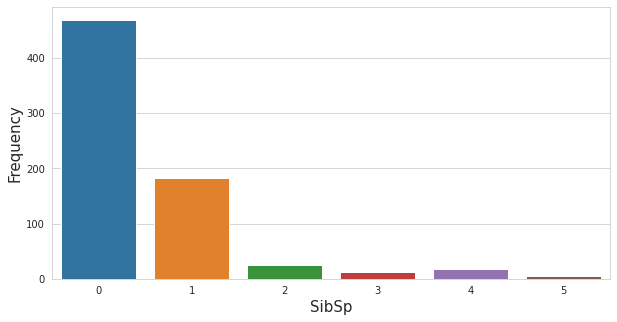

In [62]:
plt.figure(figsize=(10, 5))
sns.countplot(df['SibSp'])
plt.ylabel('Frequency', fontsize = 15)
plt.xlabel('SibSp', fontsize = 15)

Text(0, 0.5, 'Frequency')

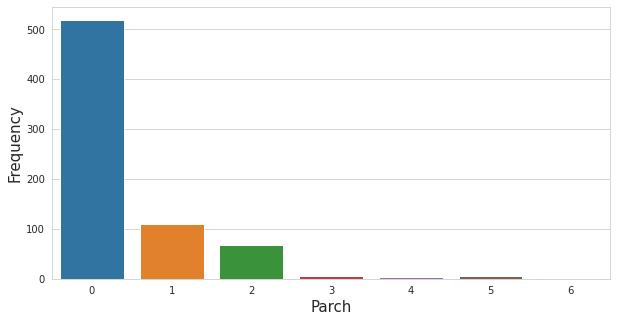

In [63]:
plt.figure(figsize=(10, 5))
sns.countplot(df['Parch'])
plt.xlabel('Parch', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)

In [64]:
df['Sex'] = [1 if x == 'male' else 0 for x in df['Sex']]
df.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_Misssing
0,0,3,1,22.0,1,0,7.2500,S,1
1,1,1,0,38.0,1,0,71.2833,C,0
2,1,3,0,26.0,0,0,7.9250,S,1
3,1,1,0,35.0,1,0,53.1000,S,0
4,0,3,1,35.0,0,0,8.0500,S,1


Text(0, 0.5, 'Survived')

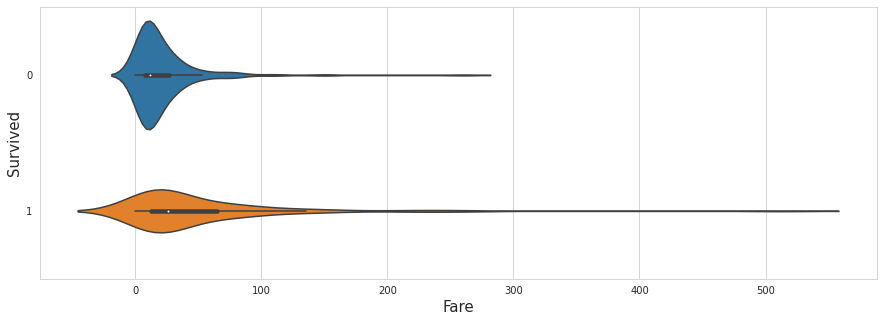

In [65]:
plt.figure(figsize=(15, 5))
sns.violinplot(y = df['Survived'], x = df['Fare'], orient = 'h')
plt.xlabel('Fare', fontsize = 15)
plt.ylabel('Survived', fontsize = 15)

<h4> Those who paid high amount for fare had higher chance of survival</h4>

Text(0.5, 0, 'Survived')

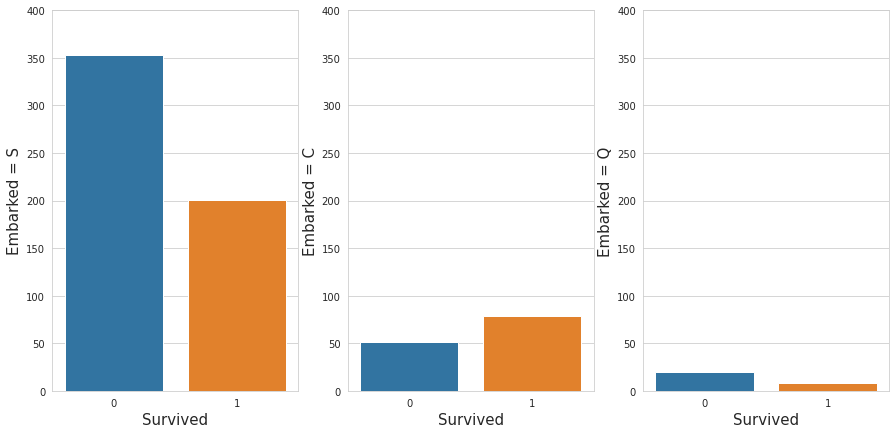

In [66]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 3, 1)
sns.countplot(x= df[df['Embarked']=='S']['Survived'])
plt.ylim(0, 400)
plt.ylabel('Embarked = S', fontsize = 15)
plt.xlabel('Survived', fontsize = 15)
plt.subplot(1,3,2)
sns.countplot(x= df[df['Embarked']=='C']['Survived'])
plt.ylim(0, 400)
plt.ylabel('Embarked = C', fontsize = 15)
plt.xlabel('Survived', fontsize = 15)
plt.subplot(1,3,3)
sns.countplot(x= df[df['Embarked']=='Q']['Survived'])
plt.ylim(0, 400)
plt.ylabel('Embarked = Q', fontsize = 15)
plt.xlabel('Survived', fontsize = 15)

Text(0.5, 0, 'Survived')

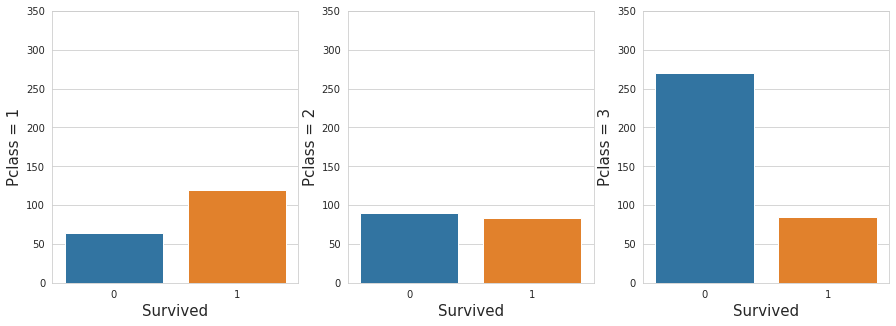

In [67]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.countplot(x= df[df['Pclass']==1]['Survived'])
plt.ylim(0, 350)
plt.ylabel('Pclass = 1', fontsize = 15)
plt.xlabel('Survived', fontsize = 15)
plt.subplot(1,3,2)
sns.countplot(x= df[df['Pclass']==2]['Survived'])
plt.ylim(0, 350)
plt.ylabel('Pclass = 2', fontsize = 15)
plt.xlabel('Survived', fontsize = 15)
plt.subplot(1,3,3)
sns.countplot(x= df[df['Pclass']==3]['Survived'])
plt.ylim(0, 350)
plt.ylabel('Pclass = 3', fontsize = 15)
plt.xlabel('Survived', fontsize = 15)

<h3> Passenger with Pclass = 3  has less than the half the chance of survival. Passenger with Pclass = 1 has higher chance of survival.</h3>

Text(0.5, 1.0, 'Fare and Age')

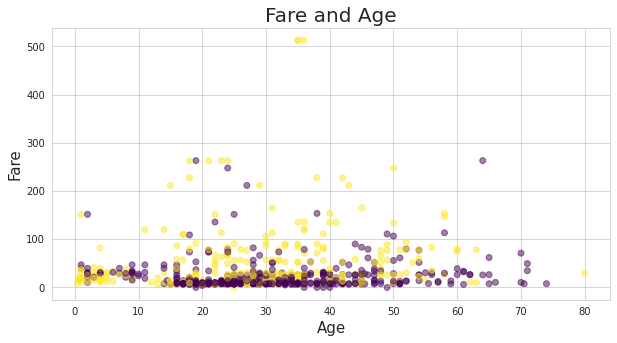

In [68]:
plt.figure(figsize=(10, 5))
plt.scatter(x = df['Age'], y = df['Fare'], alpha = 0.5,  marker = 'o', c = df['Survived'], cmap = 'viridis',)
plt.xlabel('Age', fontsize = 15)
plt.ylabel('Fare', fontsize = 15)
plt.title('Fare and Age', fontsize = 20)

<h3>Positive Points are slightly higher in number at high Fare and low Age  region</h3>

Text(0.5, 0, 'Survived')

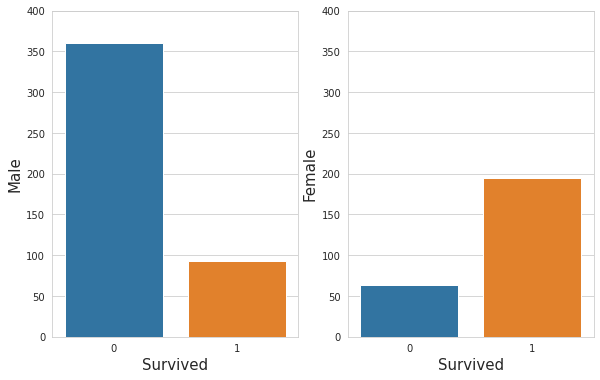

In [69]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
sns.countplot(x= df[df['Sex']==1]['Survived'])
plt.ylim(0, 400)
plt.ylabel('Male', fontsize = 15)
plt.xlabel('Survived', fontsize = 15)
plt.subplot(1,3,2)
sns.countplot(x= df[df['Sex']==0]['Survived'])
plt.ylim(0, 400)
plt.ylabel('Female', fontsize = 15)
plt.xlabel('Survived', fontsize = 15)

<h3> Male has very low chance of survival compared to Females</h3>

In [70]:
df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_Misssing
0,0,3,1,22.0,1,0,7.2500,S,1
1,1,1,0,38.0,1,0,71.2833,C,0
2,1,3,0,26.0,0,0,7.9250,S,1
3,1,1,0,35.0,1,0,53.1000,S,0
4,0,3,1,35.0,0,0,8.0500,S,1
6,0,1,1,54.0,0,0,51.8625,S,0
7,0,3,1,2.0,3,1,21.0750,S,1
8,1,3,0,27.0,0,2,11.1333,S,1
9,1,2,0,14.0,1,0,30.0708,C,1
10,1,3,0,4.0,1,1,16.7000,S,0


In [71]:
# Converting Embarked to one hot encoding
df['S'] = [1 if x == 'S' else 0 for x in df['Embarked']]
df['C'] = [1 if x == 'C' else 0 for x in df['Embarked']]
df['Q'] = [1 if x == 'Q' else 0 for x in df['Embarked']]
df.drop(['Embarked'], axis = 1, inplace = True)
df.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin_Misssing,S,C,Q
0,0,3,1,22.0,1,0,7.2500,1,1,0,0
1,1,1,0,38.0,1,0,71.2833,0,0,1,0
2,1,3,0,26.0,0,0,7.9250,1,1,0,0
3,1,1,0,35.0,1,0,53.1000,0,1,0,0
4,0,3,1,35.0,0,0,8.0500,1,1,0,0


<h3> Standardizing numerical featues Age and Fare</h3>

In [72]:
df[['Age', ['Fare']]] = (df[['Age', 'Fare']] - df[['Age', 'Fare']].mean(axis = 0))/df[['Age', 'Fare']].std(axis = 0)
print(df[['Age', 'Fare']].mean(axis =0))
print(df[['Age', 'Fare']].std(axis = 0))

Age     3.038690e-16
Fare    1.126596e-15
dtype: float64
Age     1.0
Fare    1.0
dtype: float64


<h3> Final Look at the Data </h3>

In [73]:
print(df.shape)
print(f'''Percentage of Data removed after cleaning : {100-(df.shape[0]/data.shape[0])*100}''')
df.head(10)


(712, 11)
Percentage of Data removed after cleaning : 20.08978675645342


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin_Misssing,S,C,Q
0,0,3,1,-0.527298,1,0,-0.516017,1,1,0,0
1,1,1,0,0.576688,1,0,0.693558,0,0,1,0
2,1,3,0,-0.251301,0,0,-0.503267,1,1,0,0
3,1,1,0,0.369691,1,0,0.350080,0,1,0,0
4,0,3,1,0.369691,0,0,-0.500905,1,1,0,0
6,0,1,1,1.680675,0,0,0.326704,0,1,0,0
7,0,3,1,-1.907281,3,1,-0.254866,1,1,0,0
8,1,3,0,-0.182302,0,2,-0.442662,1,1,0,0
9,1,2,0,-1.079291,1,0,-0.084937,1,0,1,0
10,1,3,0,-1.769283,1,1,-0.337509,0,1,0,0


In [74]:
X = df[df.columns[1:]]
y = df['Survived']
X.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin_Misssing,S,C,Q
0,3,1,-0.527298,1,0,-0.516017,1,1,0,0
1,1,0,0.576688,1,0,0.693558,0,0,1,0
2,3,0,-0.251301,0,0,-0.503267,1,1,0,0
3,1,0,0.369691,1,0,0.350080,0,1,0,0
4,3,1,0.369691,0,0,-0.500905,1,1,0,0


In [75]:
tsne = TSNE(n_components=2, perplexity=50, n_iter= 2500)
tsne_result = tsne.fit_transform(X)

Text(0.5, 1.0, 'TSNE plot with peplexity 30')

<Figure size 504x72 with 0 Axes>

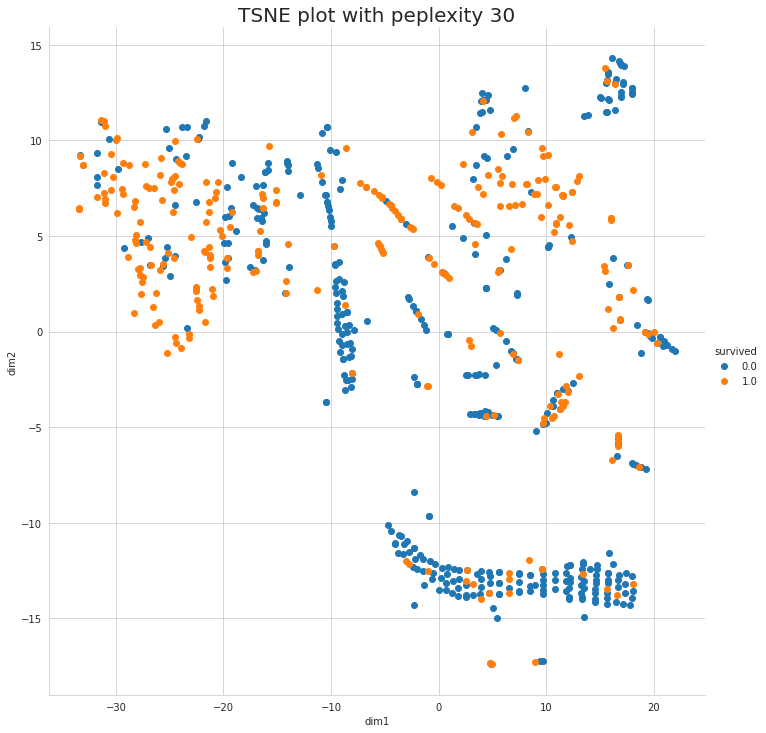

In [76]:
tsne_new = np.hstack([tsne_result, df['Survived'].values.reshape(-1, 1)])
tsne_df = pd.DataFrame(tsne_new, columns = ['dim1', 'dim2', 'survived'])
plt.figure(figsize = (7, 1))
sns.FacetGrid(tsne_df, hue = 'survived', size = 10).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title('TSNE plot with peplexity 30', fontsize = 20)

<h5> Distinction among the two class of points quite clear</h5> 

<h3>Train test Splitting</h3>

In [77]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state=0, stratify = y)
traincv_x, testcv_x, traincv_y, testcv_y = train_test_split(train_x, train_y, test_size = 0.2, random_state=0, stratify = train_y)
print('Training and Test Data')
print('-'*50)
print(f'Train_x data : {train_x.shape}')
print(f'Train_y data : {train_y.shape}')
print(f'Test_x data : {test_x.shape}')
print(f'Test_y data : {test_y.shape}')
print('-'*50)
print('Cross-validation Data')
print(f'Train_x data : {traincv_x.shape}')
print(f'Train_y data : {traincv_y.shape}')
print(f'Test_x data : {testcv_x.shape}')
print(f'Test_y data : {testcv_y.shape}')

Training and Test Data
--------------------------------------------------
Train_x data : (569, 10)
Train_y data : (569,)
Test_x data : (143, 10)
Test_y data : (143,)
--------------------------------------------------
Cross-validation Data
Train_x data : (455, 10)
Train_y data : (455,)
Test_x data : (114, 10)
Test_y data : (114,)


<h3> Balancedness in Train and Test</h3>

Text(0, 0.5, 'Frequency')

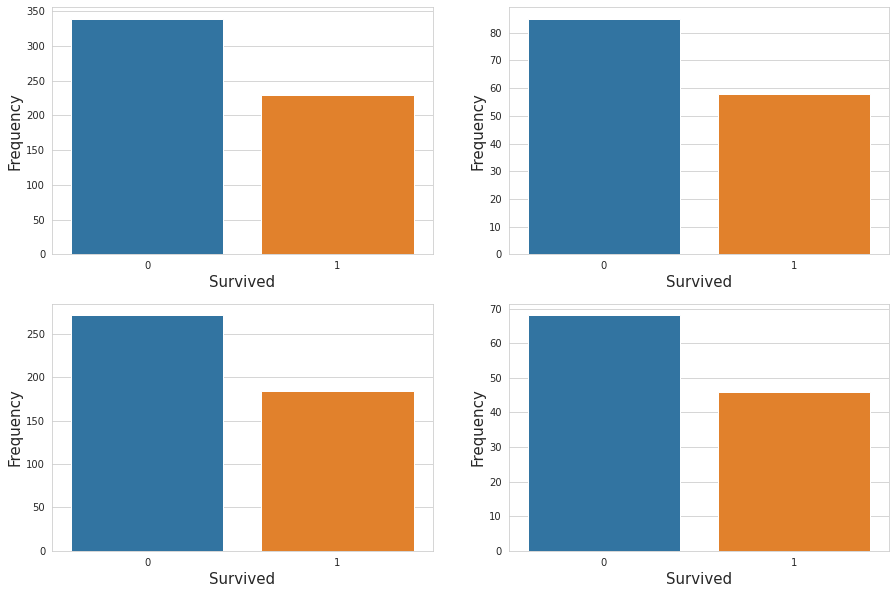

In [78]:
plt.figure(figsize = (15, 10))
plt.subplot(2, 2, 1)
sns.countplot(x = train_y)
plt.xlabel('Survived', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.subplot(2, 2, 2)
sns.countplot(x = test_y)
plt.xlabel('Survived', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.subplot(2, 2, 3)
sns.countplot(x = traincv_y)
plt.xlabel('Survived', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.subplot(2, 2, 4)
sns.countplot(x = testcv_y)
plt.xlabel('Survived', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)


<h3> ML Models</h3>

In [79]:
model_dir = '/models'
if not os.path.isdir(dir + model_dir):
  os.mkdir(dir + model_dir)

In [80]:
def plot_train_test_loss(train_loss, test_loss, hyperparam):
  plt.figure(figsize=(10, 5))
  plt.plot(hyperparam, train_loss, color = 'r', label = 'Training Loss',)
  plt.plot(hyperparam,  test_loss, color = 'g', label = 'Test Loss')
  plt.ylim(0, 50)
  plt.scatter(x = hyperparam, y = train_loss, c = 'red')
  plt.scatter(x = hyperparam, y = test_loss, c = 'g')
  plt.xlabel('Hyperparameter : ', fontsize = 10)
  plt.ylabel('Loss', fontsize = 10)
  plt.title('Training & Test Loss', fontsize = 15)
  plt.legend()
  plt.show()

<h4>1. Logistic Regression</h4>

In [81]:
file_name_loglr_rcv = dir + model_dir + '/logistic_regression_rcv.sav'
if not os.path.isfile(file_name_loglr_rcv):
  params = dict(C=uniform(loc=0, scale = 1), penalty=['l1', 'l2'])
  lr = LogisticRegression(random_state =0)
  clf = RandomizedSearchCV(lr, params, random_state =0)
  search = clf.fit(train_x, train_y)
  tuned_params = search.best_params_
  print(tuned_params)
  model_lr_rcv = LogisticRegression(C = tuned_params['C'], penalty= tuned_params['penalty'], random_state = 0).fit(train_x, train_y)
  model_lr_rcv.fit(train_x, train_y)
  pkl.dump(model_lr_rcv, open(file_name_loglr_rcv, 'wb'))
else:
  model_lr_rcv = pkl.load(open(file_name_loglr_rcv, 'rb'))

train_acc = model_lr_rcv.score(train_x, train_y)
test_acc = model_lr_rcv.score(test_x, test_y)
print(f'''Train accuracy : {train_acc}, Test accuracy : {test_acc}''')

Train accuracy : 0.7961335676625659, Test accuracy : 0.8601398601398601


In [82]:
file_name_loglr = dir + model_dir + '/logistic_regression.sav'
if not os.path.isfile(file_name_loglr):
  C = [0.0001, 0.001, 0.01, 0.1, 0, 1, 2, 5, 10, 100, 1000, 10000]
  param_grid = dict(C = C, penalty = ['l1', 'l2'])
  log_lr = LogisticRegression(random_state=0)
  model_loglr = GridSearchCV(log_lr, param_grid= param_grid, cv=5, return_train_score=True)
  model_loglr.fit(train_x, train_y)
  print("Model with best parameters :\n",model_loglr.best_params_)
  model_lr_gcv = LogisticRegression(**model_loglr.best_params_, random_state=0)
  model_lr_gcv.fit(train_x, train_y)
  pkl.dump(model_lr_gcv, open(file_name_loglr, 'wb'))
else:
  model_lr_gcv = pkl.load(open(file_name_loglr, 'rb'))
train_acc_lr = model_lr_gcv.score(train_x, train_y)
test_acc_lr = model_lr_gcv.score(test_x, test_y)
print(f'''Train accuracy : {train_acc}; Test accuracy : {test_acc}''')

Train accuracy : 0.7961335676625659; Test accuracy : 0.8601398601398601


In [83]:
lr_coef = model_lr_gcv.coef_.reshape(-1, 1)
feat_imp = pd.DataFrame(lr_coef, columns=['coef'], index = train_x.columns)
imp_feat = feat_imp.sort_values(by = 'coef', ascending = False)
imp_feat

,coef
C,0.367835
S,0.050301
Fare,0.015234
Parch,-0.176565
SibSp,-0.383826
Q,-0.417849
Age,-0.561926
Cabin_Misssing,-0.652992
Pclass,-0.858850
Sex,-2.451993


<h4>2. KNN</h4>

<h5>Weights : Uniform</h5>

In [84]:
file_name_knn = dir + model_dir + '/knn.sav'
if not os.path.isfile(file_name_knn):
  n_neighbors = [1, 3, 5, 7, 100, 569]
  weights= ['uniform', 'distance']
  param_grid = dict(n_neighbors = n_neighbors, weights = weights)
  knn = KNeighborsClassifier()
  model_knn = GridSearchCV(knn, param_grid, cv = 5, return_train_score = True)
  model_knn.fit(train_x, train_y)
  print(model_knn.best_params_)
  model_knn = KNeighborsClassifier(**model_knn.best_params_)
  model_knn.fit(train_x, train_y)
  pkl.dump(model_knn, open(file_name_knn, 'wb'))
else:
  model_knn = pkl.load(open(file_name_knn, 'rb'))
train_acc_knn = model_knn.score(train_x, train_y)
test_acc_knn = model_knn.score(test_x, test_y)
print(f'''Train accuracy : {train_acc_knn}; Test accuracy : {test_acc_knn}''')
  

Train accuracy : 0.8224956063268892; Test accuracy : 0.8391608391608392


<h5> Best performance for k = 7; Clearly the KNN model does not overfit. But Underfitting problem is there.</h5>

<h4>3. SVM</h4>

In [85]:
file_name_svm = dir + model_dir + '/svm.sav'
if not os.path.isfile(file_name_svm):
  C = [0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10, 50, 100, 1000, 10000]
  kernel = ['linear', 'poly', 'sigmoid', 'rbf']
  degree = [1, 2, 3, 5]
  gamma = ['scale', 'auto']
  param_grid_svc = dict(C = C, kernel = kernel, degree = degree, gamma = gamma)
  svm = SVC(random_state=0)
  model_svm = GridSearchCV(svm, param_grid_svc, cv = 5, return_train_score=True)
  start = time.time()
  model_svm.fit(train_x, train_y)
  end = time.time()
  print(f'''Training time: {end-start} s''')
  print(model_svm.best_params_)
  model_svm = SVC(**model_svm.best_params_, random_state=0)
  model_svm.fit(train_x, train_y)
  pkl.dump(model_svm, open(file_name_svm, 'wb'))
else:
  model_svm = pkl.load(open(file_name_svm, 'rb'))
train_acc_svm = model_svm.score(train_x, train_y)
test_acc_svm = model_svm.score(test_x, test_y)
print(f'''Train accuracy : {train_acc_svm}; Test accuracy : {test_acc_svm}''')

Train accuracy : 0.8224956063268892; Test accuracy : 0.8601398601398601


<h4>4. Naive Bayes</h4>

In [86]:
df_nb = df.copy()
df_nb['Age'] = (df['Age']-df['Age'].min())/(df['Age'].max()-df['Age'].min())
df_nb['Fare'] = (df['Fare']-df['Fare'].min())/(df['Fare'].max()-df['Fare'].min())
train_nb_x, test_nb_x, train_nb_y, test_nb_y = train_test_split(df_nb[df_nb.columns[1:]], df_nb['Survived'], test_size = 0.2, random_state=0, stratify = y)

In [87]:
file_name_nb = dir + model_dir + '/naive_bayes.sav'
if not os.path.isfile(file_name_nb):
  alpha = [0.0001, 0.001, 0.01, 0.1, 0, 1, 10, 100, 1000, 10000]
  param_grid = dict(alpha = alpha)
  nb = MultinomialNB()
  model_nb = GridSearchCV(nb, param_grid, cv = 5, return_train_score= True)
  start = time.time()
  model_nb.fit(train_nb_x, train_nb_y)
  end = time.time()
  print(f'''Training time: {end-start}''')
  print(model_nb.best_params_)
  model_nb = MultinomialNB(**model_nb.best_params_)
  model_nb.fit(train_nb_x, train_nb_y)
  pkl.dump(model_nb, open(file_name_nb, 'wb'))
else:
  model_nb = pkl.load(open(file_name_nb, 'rb'))
train_acc_nb = model_nb.score(train_nb_x, train_nb_y)
test_acc_nb = model_nb.score(test_nb_x, test_nb_y)
print(f'''Train accuracy : {train_acc_nb}; Test accuracy : {test_acc_nb}''')

Train accuracy : 0.671353251318102; Test accuracy : 0.7412587412587412


<h4>5. Decision Trees</h4>

In [88]:
file_name_dt = dir + model_dir + '/decision_tree.sav'
if not os.path.isfile(file_name_dt):
  criterion = ['gini', 'entropy']
  splitter = ['best', 'random']
  max_depth = [1, 2, 3, 4, 5, 6, 7, 8]
  min_samples_split = [2, 4, 8, 16, 32, 64]
  max_features = ['auto', 'sqrt', 'log2', 'None', 0.1, 0.2, 0.3, 0.4, 0.5]
  param_grid = dict(criterion = criterion, splitter = splitter, max_depth = max_depth, min_samples_split = min_samples_split, max_features = max_features)

  dt = DecisionTreeClassifier(random_state = 0)
  model_dt = GridSearchCV(dt, param_grid, cv = 5, return_train_score = True)
  start = time.time()
  model_dt.fit(train_x, train_y)
  end = time.time()
  print(f'Training Time : {end-start}')
  print(model_dt.best_params_)
  model_dt = DecisionTreeClassifier(**model_dt.best_params_, random_state=0)
  model_dt.fit(train_x, train_y)
  pkl.dump(model_dt, open(file_name_dt, 'wb'))
else:
  model_dt = pkl.load(open(file_name_dt, 'rb'))
train_acc_dt = model_dt.score(train_x, train_y)
test_acc_dt = model_dt.score(test_x, test_y)
print(f'''Train accuracy : {train_acc_dt}; Test accuracy : {test_acc_dt}''')

Train accuracy : 0.8347978910369068; Test accuracy : 0.8531468531468531


In [89]:
feat_imp = pd.Series(model_dt.feature_importances_, index = train_x.columns)
feat_imp.sort_values(ascending = False, inplace = True)
pd.DataFrame(feat_imp, columns = ['Feature Imp'])

,Feature Imp
Sex,0.432083
Cabin_Misssing,0.196036
Age,0.130082
Pclass,0.109463
SibSp,0.071346
Fare,0.047878
C,0.013111
Q,0.000000
S,0.000000
Parch,0.000000


<h4>6. Random Forest</h4>

In [90]:
file_name_rf = dir + model_dir + '/random_forest.sav'
if not os.path.isfile(file_name_rf):
  # n_estimators = [5, 10, 50, 100, 200, 500, 1000, 10000]
  n_estimators = [100, 500, 1000, 10000]
  max_depth = [5, 6, 7, 8, 10, 15]
  max_samples = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
  rf_param_grid = dict(n_estimators = n_estimators, max_depth = max_depth, max_samples = max_samples)
  # param_grid['max_samples'] = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
  # rf_param_grid['max_samples'] = [0.2, 0.3]
  # rf_param_grid['max_depth'] = [3, 4]
  # rf_param_grid['min_samples_split'] = [8, 16]
  # del param_grid['splitter']
  rf = RandomForestClassifier(random_state = 0)
  model = GridSearchCV(rf, rf_param_grid, cv = 5, return_train_score=True)
  start = time.time()
  model.fit(train_x, train_y)
  end = time.time()
  print(f'Training time: {end-start}')
  print(model.best_params_)

  model_rf = RandomForestClassifier(**model.best_params_, random_state=0, n_jobs = -1)
  model_rf.fit(train_x, train_y)
  pkl.dump(model_rf, open(file_name_rf, 'wb'))
else:
  model_rf = pkl.load(open(file_name_rf, 'rb'))

train_acc_rf = model_rf.score(train_x, train_y)
test_acc_rf = model_rf.score(test_x, test_y)
print(f'''Train accuracy : {train_acc_rf}; Test accuracy : {test_acc_rf}''')

Train accuracy : 0.9138840070298769; Test accuracy : 0.8321678321678322


<h4>7. XGBoost </h4> 

In [91]:
file_name_xgb = dir + model_dir + '/xgboost.sav'
if not os.path.isfile(file_name_xgb):
  print('hkkhj') 
  clf = XGBClassifier(n_jobs= -1, class_weight='balanced')
  no_of_estimators = [5, 10, 50, 100, 120, 150, 200, 500]
  maximumdepth = [1, 5, 7, 10, 15, 25, 30]
  parameters = {'n_estimators': no_of_estimators ,'max_depth':maximumdepth}
  model_xgb = GridSearchCV(estimator=clf, param_grid=parameters, cv=5, n_jobs=-1, return_train_score=True)
  model_xgb.fit(train_x, train_y)
  print("Model with best parameters :\n",model_xgb.best_params_)

  model_xgb = XGBClassifier(**model_xgb.best_params_, random_state=0, n_jobs = -1)
  model_xgb.fit(train_x, train_y)
  pkl.dump(model_rf, open(file_name_xgb, 'wb'))
else:
  model_xgb = pkl.load(open(file_name_xgb, 'rb'))

train_acc_xgb = model_xgb.score(train_x, train_y)
test_acc_xgb = model_xgb.score(test_x, test_y)
print(f'''Train accuracy : {train_acc_xgb}; Test accuracy : {test_acc_xgb}''')

Train accuracy : 0.9138840070298769; Test accuracy : 0.8321678321678322


<h4>Running Final Model on Test Data</h4>

In [92]:
test_data = pd.read_csv(dir + '/test.csv')
test_data.tail(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


In [93]:
print(f'''No of Duplicate rows: {len(test_data) - test_data[test_data.duplicated(['Name'])==False].shape[0]}''')
pd.DataFrame(100*test_data.isnull().sum()/test_data.shape[0], columns=['Missing (in %)'])

No of Duplicate rows: 0


,Missing (in %)
PassengerId,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
Age,20.574163
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.239234
Cabin,78.229665


In [94]:
median_age = df['Age'].median()
median_fare = df['Fare'].median()
print(f'Avg Age: {median_age}| Average Fare : {median_fare}')
test_data['Cabin_Misssing'] = test_data['Cabin'].isnull().map(lambda x : 1 if x==True else 0)
 
test_data['Age'] = (test_data['Age'] - test_data['Age'].mean())/test_data['Age'].std()
test_data['Fare'] = (test_data['Fare'] - test_data['Fare'].mean())/test_data['Fare'].std()

test_data['Age'] = test_data['Age'].map(lambda x: median_age if pd.isna(x) else x)
test_data['Fare'] = test_data['Fare'].map(lambda x: median_fare if pd.isna(x) else x)

# Converting Embarked to one hot encoding
test_data['S'] = [1 if x == 'S' else 0 for x in test_data['Embarked']]
test_data['C'] = [1 if x == 'C' else 0 for x in test_data['Embarked']]
test_data['Q'] = [1 if x == 'Q' else 0 for x in test_data['Embarked']]

test_data['Sex'] = [1 if x == 'male' else 0 for x in test_data['Sex']]

# saving Passenger ids before dropping
pids = test_data['PassengerId']

test_data.drop(['Cabin', 'Name', 'Ticket', 'Embarked', 'PassengerId'], axis = 1, inplace=True)

test_data.tail(5)

Avg Age: -0.11330299449551398| Average Fare : -0.35742131801418364


,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin_Misssing,S,C,Q
413,3,1,-0.113303,0,0,-0.493264,1,1,0,0
414,1,0,0.615421,0,0,1.310606,0,0,1,0
415,3,1,0.580163,0,0,-0.507573,1,1,0,0
416,3,1,-0.113303,0,0,-0.493264,1,1,0,0
417,3,1,-0.113303,1,1,-0.237336,1,0,1,0


In [95]:
test_pred = model_xgb.predict(test_data)
test_pred

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [96]:
final_submission = pd.DataFrame(zip(pids, test_pred), columns = ['PassengerId', 'Survived'])
final_submission.to_csv(dir + '/submission_1.csv', index = False)